In [28]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV


from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

import numpy as np
import matplotlib.pyplot as plt

In [29]:
df = pd.read_csv('./data/final_df.csv')

In [30]:
# Cheking data frame shape
display(df.shape)
#Checking if there is a null value
display(df.isnull().sum().sum())
#Checking column names
#df.columns

(1848, 14)

0

## Base Line accuracy

In [31]:
df['label'].value_counts(normalize=1)[0:1]  # value and pct

1    0.509199
Name: label, dtype: float64

## Features:

In [32]:
feat_title = ['title']
feat_clean_title = ['clean_title'] 
feat_tit_lemma = ['clean_title_lemmat'] ## Highest Scores
feat_tit_landcast = ['clean_title_lancast'] 
feat_tit_port = ['clean_title_port'] 
features = feat_tit_lemma 

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1848 entries, 0 to 1849
Data columns (total 14 columns):
title                     1848 non-null object
selftext                  1848 non-null object
ups                       1848 non-null int64
num_comments              1848 non-null int64
author                    1848 non-null object
label                     1848 non-null int64
clean_title               1848 non-null object
clean_selftext            1848 non-null object
clean_title_lemmat        1848 non-null object
clean_title_lancast       1848 non-null object
clean_title_port          1848 non-null object
clean_selftext_lemmat     1848 non-null object
clean_selftext_lancast    1848 non-null object
clean_selftext_port       1848 non-null object
dtypes: int64(3), object(11)
memory usage: 296.6+ KB


## Split test:

In [33]:
#Preparing data
X = df[features].iloc[:,0]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)

### Testing wich steamer / lemmatizer give best resoults in multinomialNB 

In [34]:
cv = CountVectorizer()
model_mult_nb = MultinomialNB()
alphas = np.linspace(0,2,20)[1:]

pipe = Pipeline([('cv',cv),
                ('model',model_mult_nb)
])

In [35]:
params = {'cv__stop_words': [['honda','toyota',]]#,'civic','accord','camry','corolla','highlander']],
#           'cv__max_features':[4000,5000,6000,None],
#          'cv__ngram_range': [(1,1)],
#          'cv__min_df': [1,5,10,15],
#          'cv__max_df':[0.10,0.15,0.2,0.3],
#           'model__alpha' : alphas
    }
gs = GridSearchCV(pipe, param_grid=params,cv=5)
print(gs.fit(X_train,y_train))
print(gs.best_params_)
print("Train Score: ", round(gs.best_score_,4))
print("Train Score: ", round(gs.score(X_test,y_test),4))


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'cv__stop_words': [['honda', 'toyota']]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
{'cv__stop_words': ['honda', 'toyota']}
Train Score:  0.8066
Train Score:  0.7771


* LancasterStemmer yielded highest score in a multinomialNB model, using only title as feature.

## Vectorizing and Appending other features:

In [36]:
vectorizer = CountVectorizer(stop_words=['honda','toyota'])
X_train_title_vec = vectorizer.fit_transform(X_train)
X_test_title_vec = vectorizer.transform(X_test)

print("Dic Size:", len(vectorizer.get_feature_names()))

Dic Size: 2681


In [37]:
new_train_df = pd.DataFrame()
new_test_df = pd.DataFrame()

for i, col in enumerate(vectorizer.get_feature_names()):
    new_train_df[col] = pd.SparseSeries(X_train_title_vec[:, i].toarray().ravel(), fill_value=0)
    
for i, col in enumerate(vectorizer.get_feature_names()):
    new_test_df[col] = pd.SparseSeries(X_test_title_vec[:, i].toarray().ravel(), fill_value=0)

#### Adding features:

In [38]:
## Adding to Train data frame
ups_train_list = []
comment_train_list = []
for row_numb in X_train.index:
    ups_train_list.append(df.loc[row_numb,['ups']][0])
    comment_train_list.append(df.loc[row_numb,['num_comments']][0])

new_train_df['ups'] = ups_train_list
new_train_df['num_comments'] = comment_train_list

## Adding to Test data frame
ups_test_list = []
comment_test_list = []
for row_numb in X_test.index:
    ups_test_list.append(df.loc[row_numb,['ups']][0])
    comment_test_list.append(df.loc[row_numb,['num_comments']][0])
new_test_df['ups'] = ups_test_list
new_test_df['num_comments'] = comment_test_list


### Running the same model with new features:

In [39]:
# for alpha in np.linspace(0,2,20)[1:]:
model_mult_nb = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
model_mult_nb.fit(new_train_df,y_train)
print("Train score", model_mult_nb.score(new_train_df,y_train))
print("Test score", model_mult_nb.score(new_test_df,y_test))

Train score 0.8311688311688312
Test score 0.6991341991341992


### Results:
* New features did not increase the model performance.

### Multinomial Naive Bayes

# Comparing different models using title feature 

In [40]:
cv = CountVectorizer()
model_mult_nb = MultinomialNB()
params = {'cv__stop_words': [['honda','toyota']]}
gs = GridSearchCV(pipe, param_grid=params,cv=5)
print(gs.fit(X_train,y_train))
print(gs.best_params_)
print("Train Score: ", round(gs.best_score_,4))
print("Train Score: ", round(gs.score(X_test,y_test),4))


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'cv__stop_words': [['honda', 'toyota']]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
{'cv__stop_words': ['honda', 'toyota']}
Train Score:  0.8066
Train Score:  0.7771


### Random Forest ####

In [41]:
vectorizer = CountVectorizer(stop_words=['honda','toyota'])
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_vec,y_train)
print("Cross Val Score: ",cross_val_score(rf,X_train_vec,y_train,cv=5).mean())
print("Train Score: ", round(rf.score(X_train_vec,y_train),4))
print("Train Score: ", round(rf.score(X_test_vec,y_test),4))


C:\Users\berku\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Cross Val Score:  0.7582681868945278
Train Score:  0.9899
Train Score:  0.7706


### Extra Trees #####

In [42]:
vectorizer = CountVectorizer(stop_words=['honda','toyota'])
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
et = ExtraTreesClassifier(random_state=42)
et.fit(X_train_vec,y_train)
print("Cross Val Score: ",cross_val_score(rf,X_train_vec,y_train,cv=5).mean())
print("Train Score: ", round(et.score(X_train_vec,y_train),4))
print("Test Score: ", round(et.score(X_test_vec,y_test),4))

C:\Users\berku\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Cross Val Score:  0.7582681868945278
Train Score:  0.9993
Test Score:  0.7879


### Baggin Classifier ####

In [43]:
vectorizer = CountVectorizer(stop_words=['honda','toyota'])
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

bagged = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42)
                            ,max_samples=0.5, max_features=0.5)
bagged.fit(X_train_vec,y_train)
print("Cross Val Score: ",cross_val_score(bagged,X_train_vec,y_train,cv=5).mean())
print("Train Score: ",bagged.score(X_train_vec,y_train))
print("Test Score: ",bagged.score(X_test_vec,y_test))
                             

Cross Val Score:  0.7395138041191596
Train Score:  0.9523809523809523
Test Score:  0.7532467532467533


## Tuning Random Forest

In [55]:
vectorizer = CountVectorizer(stop_words=['honda','toyota'])
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
model__max_features = ['auto',0.75,0.8,0.4]
model__max_depth = [65,66,67,68,69,70]#,200]
model__criterion = ['gini', 'entropy']
sample_leaf_options = [1,5,10,50,100,200,500]
results = []
for crit in model__criterion:
    for feat in model__max_features:
        for depth in model__max_depth:
#             print (crit, feat,depth) ## min_samples_leaf=model_min_samples_leaf,n_estimators = [20] 
#             et = ExtraTreesClassifier(random_st ate=42, criterion=crit,max_depth=depth,max_features=feat)
            rf = RandomForestClassifier(n_estimators = 10,random_state=42, criterion=crit,max_depth=depth,max_features=feat
                                       ,min_samples_leaf = 1)
            rf.fit(X_train_vec,y_train)
            cv_score = round(cross_val_score(rf,X_train_vec,y_train,cv=5).mean(),5)
            train_score = round(rf.score(X_train_vec,y_train),5)
            test_score = round(rf.score(X_test_vec,y_test),5)            
            results.append([crit,feat,depth,cv_score,train_score,test_score])

In [56]:
results
# et -> ['gini', 'auto', 75, 1.0, 0.95166, 0.81169],

[['gini', 'auto', 65, 0.75684, 0.91198, 0.75108],
 ['gini', 'auto', 66, 0.75755, 0.91198, 0.7619],
 ['gini', 'auto', 67, 0.75396, 0.91486, 0.7619],
 ['gini', 'auto', 68, 0.75685, 0.91991, 0.75541],
 ['gini', 'auto', 69, 0.75972, 0.92424, 0.76407],
 ['gini', 'auto', 70, 0.76404, 0.92136, 0.74892],
 ['gini', 0.75, 65, 0.75396, 0.8925, 0.75974],
 ['gini', 0.75, 66, 0.75612, 0.89322, 0.7619],
 ['gini', 0.75, 67, 0.75396, 0.89683, 0.7619],
 ['gini', 0.75, 68, 0.75973, 0.89827, 0.7619],
 ['gini', 0.75, 69, 0.75756, 0.90115, 0.75758],
 ['gini', 0.75, 70, 0.75684, 0.90404, 0.75974],
 ['gini', 0.8, 65, 0.75251, 0.90115, 0.75758],
 ['gini', 0.8, 66, 0.74962, 0.9062, 0.75325],
 ['gini', 0.8, 67, 0.75468, 0.90765, 0.75325],
 ['gini', 0.8, 68, 0.7554, 0.90765, 0.75541],
 ['gini', 0.8, 69, 0.75179, 0.90476, 0.75325],
 ['gini', 0.8, 70, 0.75251, 0.90476, 0.75974],
 ['gini', 0.4, 65, 0.75394, 0.8961, 0.75758],
 ['gini', 0.4, 66, 0.75394, 0.89683, 0.75758],
 ['gini', 0.4, 67, 0.75611, 0.89827, 0.75758]

### Runing Random forest with optimal HyperParameters

In [57]:
# 'entropy', 'auto', None, 1.0, 0.99856, 0.73593
vectorizer = CountVectorizer(stop_words=['honda','toyota'])
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
rf = RandomForestClassifier(random_state=42,criterion='entropy',max_features='auto',max_depth=70)
rf.fit(X_train_vec,y_train)
print("Cross Val Score: ",cross_val_score(rf,X_train_vec,y_train,cv=5).mean())
print("Train Score: ", round(rf.score(X_train_vec,y_train),4))
print("Test Score: ", round(rf.score(X_test_vec,y_test),4))

C:\Users\berku\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Cross Val Score:  0.7691192894060203
Train Score:  0.8954
Test Score:  0.7706


### Printing Random Forest top features:

In [47]:
## et = the ExtraTreesClassifier that i used to fit my model
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(0,20): # X_train_vec.shape[1]
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]),new_train_df.iloc[:,indices[f]].name)


Feature ranking:
1. feature 511 (0.084429) camry
2. feature 575 (0.066664) civic
3. feature 671 (0.060441) corolla
4. feature 234 (0.050761) accord
5. feature 1214 (0.032555) highlander
6. feature 2493 (0.019741) type
7. feature 2162 (0.016490) si
8. feature 1934 (0.016041) rav4
9. feature 165 (0.013356) 4runner
10. feature 2322 (0.013130) supra
11. feature 539 (0.009167) celica
12. feature 936 (0.008807) ex
13. feature 2462 (0.008047) trd
14. feature 1499 (0.007810) lx
15. feature 711 (0.007406) crv
16. feature 1869 (0.007249) prius
17. feature 1628 (0.006847) mr2
18. feature 712 (0.006792) crx
19. feature 1310 (0.006462) insight
20. feature 707 (0.006066) cruiser


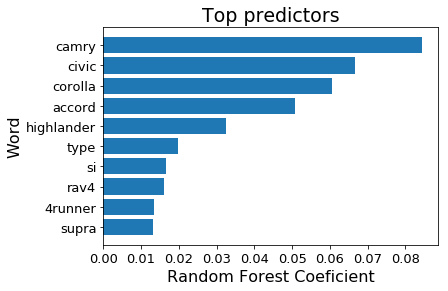

<Figure size 936x936 with 0 Axes>

In [50]:
# Make dataset
number_features_print = 10
height = [importances[indices[i]] for i in range(0,number_features_print)]
# bars = ['toyot', 'hond', 'civ', 'camry', 'accord','coroll','rav4','highland']
bars = [new_train_df.iloc[:,indices[x]].name for x in range(0,number_features_print)]


height.reverse()
bars.reverse()

y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)
plt.title('Top predictors',fontsize=19)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.ylabel('Word', fontsize = 16)
plt.xlabel('Random Forest Coeficient', fontsize = 16)
plt.figure(figsize=(13, 13))

# Show graphic
plt.show();

## Results:
* Car names are among most important predictors in the random forest model.

* The model is overfit with a 95% accuracy in training data.
* The test score was similar to cross validation score (aprox. 76%). The model is espected to have 76% accuracy in new data. 
* Hiper parameter tuning had a small improvement in scores compared to the default options. A 0.01 improvement in cross validation and test was acheaved changing max_depth to 70 and criterion to enthropy.